# Suy đoán tư thế

In [1]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch

test_image = './data/dancer.jpg'

ModuleNotFoundError: No module named 'cv2'

In [2]:
from utils.openpose_net import OpenPoseNet

net = OpenPoseNet()

# load weights of model
net_weights = torch.load(
    './weights/openpose_net_1.pth', map_location={'cuda:0': 'cpu'})
keys = list(net_weights.keys())

weights_load = {}


for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]
                 ] = net_weights[list(keys)[i]]

state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print('load done')


ModuleNotFoundError: No module named 'cv2'

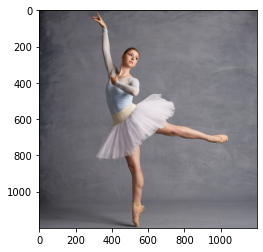

In [40]:
# Read image

oriImg = cv2.imread(test_image)  # B,G,R

# BGR->RGB
oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# Resize
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)
img = img.astype(np.float32) / 255.

# chuẩn hóa
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

preprocessed_img = img.copy()  

for i in range(3):
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - color_mean[i]
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / color_std[i]

# （height 、width、colors）→（colors、height、width）
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# cho thông tin vào tensor
img = torch.from_numpy(img)

x = img.unsqueeze(0)


In [41]:
# Tạo heatmap
net.eval()
predicted_outputs, _ = net(x)

pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(
    pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(
    heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
print(heatmaps)


[[[0.00472574 0.00513524 0.00574426 ... 0.00335757 0.00364162 0.88285995]
  [0.00472574 0.00513524 0.00574424 ... 0.00335759 0.00364166 0.88285995]
  [0.00472576 0.00513527 0.00574418 ... 0.00335768 0.00364182 0.8828597 ]
  ...
  [0.00471781 0.00517303 0.00568664 ... 0.00335603 0.00360043 0.8828237 ]
  [0.0047179  0.00517293 0.00568662 ... 0.00335605 0.0036003  0.8828236 ]
  [0.00471792 0.00517291 0.00568661 ... 0.00335605 0.00360027 0.8828236 ]]

 [[0.00472572 0.00513522 0.00574426 ... 0.00335757 0.00364164 0.8828599 ]
  [0.00472573 0.00513523 0.00574424 ... 0.00335758 0.00364168 0.8828599 ]
  [0.00472575 0.00513526 0.00574417 ... 0.00335767 0.00364185 0.8828597 ]
  ...
  [0.00471779 0.00517303 0.00568662 ... 0.00335602 0.00360046 0.8828236 ]
  [0.00471788 0.00517293 0.0056866  ... 0.00335603 0.00360033 0.8828236 ]
  [0.0047179  0.00517291 0.0056866  ... 0.00335603 0.0036003  0.8828236 ]]

 [[0.00472567 0.00513516 0.00574425 ... 0.00335752 0.00364175 0.8828597 ]
  [0.00472567 0.005135

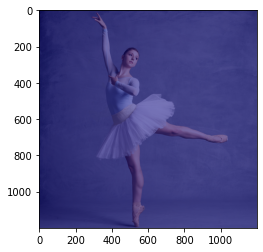

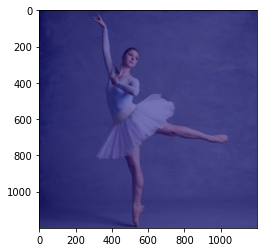

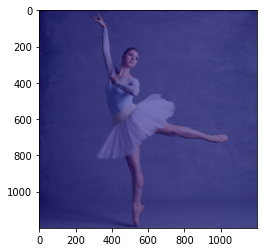

In [42]:
# Xem 1 số heatmap
heat_map = heatmaps[:, :, 6]  # 6: khửu tay
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


heat_map = heatmaps[:, :, 7]  # 7はcổ tay
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

# xem paf vectors
paf = pafs[:, :, 24]
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))
paf = np.asarray(paf.convert('RGB'))


blend_img = cv2.addWeighted(oriImg, 0.5, paf, 0.5, 0)
plt.imshow(blend_img)
plt.show()


In [43]:
from utils.decode_pose import decode_pose
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)


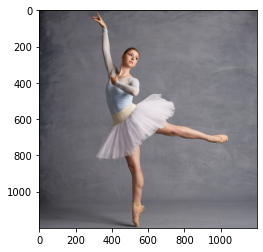

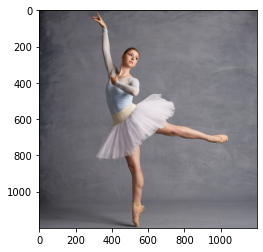

In [44]:
# 結果を描画
plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()
